In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janatahack-crosssell-prediction/test.csv
/kaggle/input/janatahack-crosssell-prediction/train.csv


Janatahack: Cross-sell Prediction
    
Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

Evaluation Metric
The evaluation metric for this hackathon is ROC_AUC score.

In [2]:
# import standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [3]:
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,cross_val_score,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import scikitplot as skplt
from sklearn.model_selection import RandomizedSearchCV

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from bayes_opt import BayesianOptimization

In [4]:
# deep learning RNN / LSTM models

from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import LSTM,GRU
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [5]:
# read the train and test dataset

train = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/train.csv')
test  = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/test.csv')

In [6]:
# explore the dataset

train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [7]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [8]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [9]:
test.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
dtype: object

In [10]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [11]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [12]:
train.shape,test.shape

((381109, 12), (127037, 11))

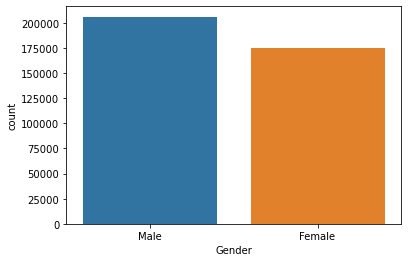

In [13]:
sns.countplot(train.Gender)

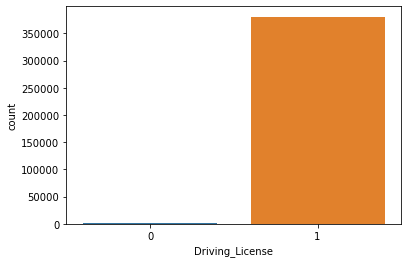

In [14]:
sns.countplot(train.Driving_License)

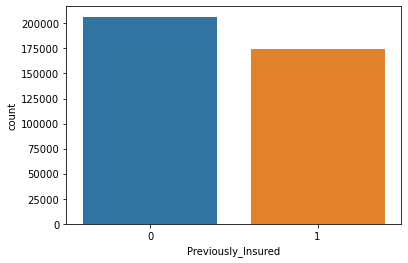

In [15]:
sns.countplot(train.Previously_Insured)

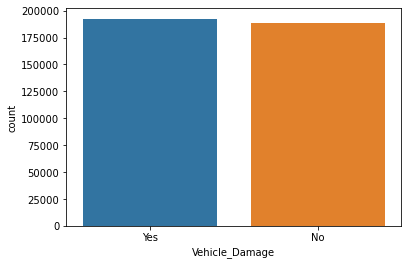

In [16]:
sns.countplot(train.Vehicle_Damage)

In [17]:
train.Region_Code.unique()

array([28.,  3., 11., 41., 33.,  6., 35., 50., 15., 45.,  8., 36., 30.,
       26., 16., 47., 48., 19., 39., 23., 37.,  5., 17.,  2.,  7., 29.,
       46., 27., 25., 13., 18., 20., 49., 22., 44.,  0.,  9., 31., 12.,
       34., 21., 10., 14., 38., 24., 40., 43., 32.,  4., 51., 42.,  1.,
       52.])

In [18]:
train.Policy_Sales_Channel.unique()

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157., 122.,
        19.,  22.,  15., 154.,  16.,  52., 155.,  11., 151., 125.,  25.,
        61.,   1.,  86.,  31., 150.,  23.,  60.,  21., 121.,   3., 139.,
        12.,  29.,  55.,   7.,  47., 127., 153.,  78., 158.,  89.,  32.,
         8.,  10., 120.,  65.,   4.,  42.,  83., 136.,  24.,  18.,  56.,
        48., 106.,  54.,  93., 116.,  91.,  45.,   9., 145., 147.,  44.,
       109.,  37., 140., 107., 128., 131., 114., 118., 159., 119., 105.,
       135.,  62., 138., 129.,  88.,  92., 111., 113.,  73.,  36.,  28.,
        35.,  59.,  53., 148., 133., 108.,  64.,  39.,  94., 132.,  46.,
        81., 103.,  90.,  51.,  27., 146.,  63.,  96.,  40.,  66., 100.,
        95., 123.,  98.,  75.,  69., 130., 134.,  49.,  97.,  38.,  17.,
       110.,  80.,  71., 117.,  58.,  20.,  76., 104.,  87.,  84., 137.,
       126.,  68.,  67., 101., 115.,  57.,  82.,  79., 112.,  99.,  70.,
         2.,  34.,  33.,  74., 102., 149.,  43.,   

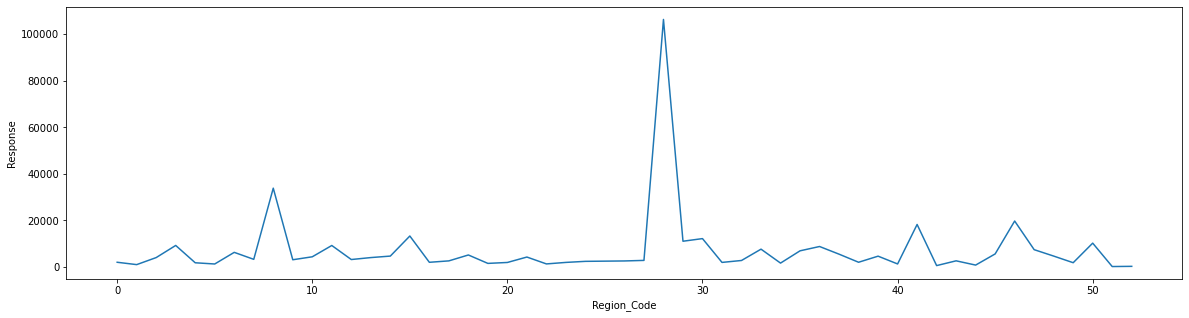

In [19]:
fig = plt.figure(figsize=(20,5))
df_region =  train['Response'].groupby(train.Region_Code).count()
df_region = pd.DataFrame(df_region)
sns.lineplot(df_region.index,df_region.Response)

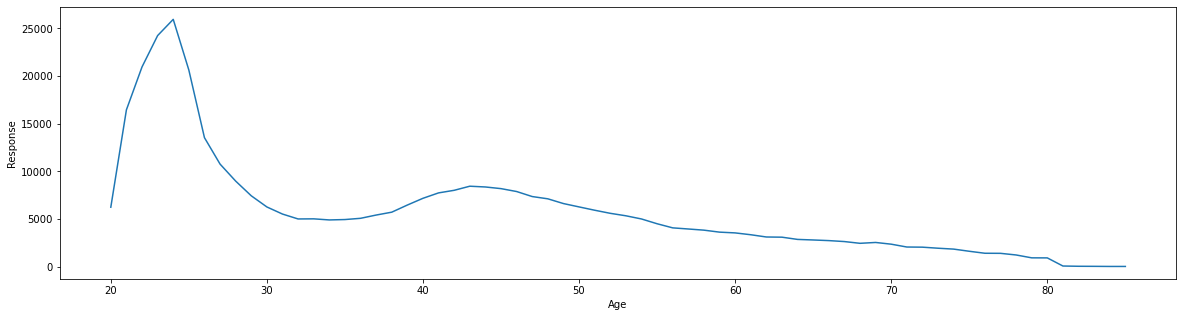

In [20]:
fig = plt.figure(figsize=(20,5))
df_age =  train['Response'].groupby(train.Age).count()
df_age = pd.DataFrame(df_age)
sns.lineplot(df_age.index,df_age.Response)

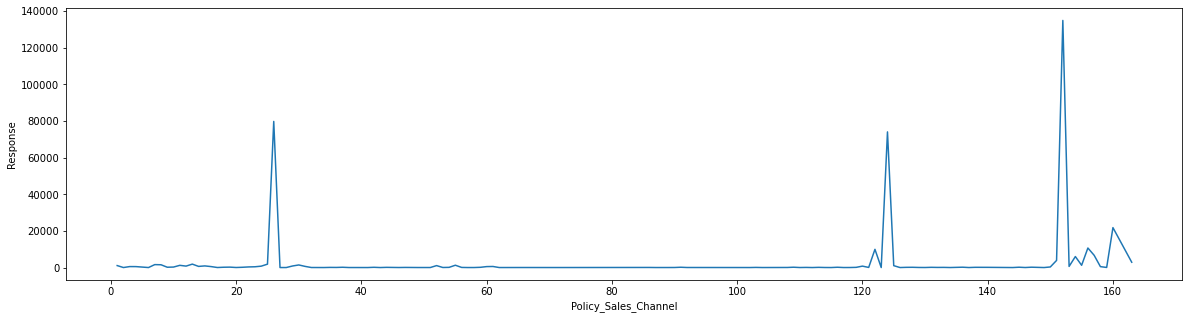

In [21]:
fig = plt.figure(figsize=(20,5))
df_sa =  train['Response'].groupby(train.Policy_Sales_Channel).count()
df_sa = pd.DataFrame(df_sa)
sns.lineplot(df_sa.index,df_sa.Response)

In [22]:
train.Vehicle_Age.value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [23]:
test.Vehicle_Age.value_counts()

1-2 Year     66699
< 1 Year     55019
> 2 Years     5319
Name: Vehicle_Age, dtype: int64

In [24]:
# one hot encode vehicle age

def mapva(x) :
    if x == '> 2 Years' :
        return 2
    elif x == '1-2 Year' :
        return 1
    elif x == '< 1 Year' :
        return 0
        
train.Vehicle_Age = train.Vehicle_Age.apply(lambda x : mapva(x))
test.Vehicle_Age  = test.Vehicle_Age.apply(lambda x : mapva(x))    

In [25]:
train.Vehicle_Age.value_counts()

1    200316
0    164786
2     16007
Name: Vehicle_Age, dtype: int64

In [26]:
test.Vehicle_Age.value_counts()

1    66699
0    55019
2     5319
Name: Vehicle_Age, dtype: int64

In [27]:
le = LabelEncoder()

train.Gender = le.fit_transform(train.Gender)
train.Vehicle_Damage = le.fit_transform(train.Vehicle_Damage)

test.Gender = le.fit_transform(test.Gender)
test.Vehicle_Damage = le.fit_transform(test.Vehicle_Damage)

In [28]:
# feature engineering - Premium paid per day PPD

train['PPD'] = train.Annual_Premium / train.Vintage
test['PPD']  = test.Annual_Premium / test.Vintage

In [29]:
train.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,PPD
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1,186.423963
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0,183.256831


In [30]:
test.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,PPD
0,381110,1,25,1,11.0,1,0,0,35786.0,152.0,53,675.207547
1,381111,1,40,1,28.0,0,1,1,33762.0,7.0,111,304.162162


In [31]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'PPD'],
      dtype='object')

In [32]:
test.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'PPD'],
      dtype='object')

In [33]:
# create X,y for the model

X = train[['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 
       'Policy_Sales_Channel','PPD']].values

#X = train[['Gender', 'Age', 'Driving_License', 'Region_Code',
#       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#       'Vintage']].values
           
y = train.Response.values
           
Xtst = test[['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 
       'Policy_Sales_Channel','PPD']].values

#Xtst = test[['Gender', 'Age', 'Driving_License', 'Region_Code',
#       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#       'Vintage']].values

X    = np.array(X)
y    = np.array(y)
Xtst = np.array(Xtst)

In [34]:
X

array([[1.00000000e+00, 4.40000000e+01, 1.00000000e+00, ...,
        1.00000000e+00, 2.60000000e+01, 1.86423963e+02],
       [1.00000000e+00, 7.60000000e+01, 1.00000000e+00, ...,
        0.00000000e+00, 2.60000000e+01, 1.83256831e+02],
       [1.00000000e+00, 4.70000000e+01, 1.00000000e+00, ...,
        1.00000000e+00, 2.60000000e+01, 1.41829630e+03],
       ...,
       [1.00000000e+00, 2.10000000e+01, 1.00000000e+00, ...,
        0.00000000e+00, 1.60000000e+02, 2.18124224e+02],
       [0.00000000e+00, 6.80000000e+01, 1.00000000e+00, ...,
        1.00000000e+00, 1.24000000e+02, 6.02932432e+02],
       [1.00000000e+00, 4.60000000e+01, 1.00000000e+00, ...,
        0.00000000e+00, 2.60000000e+01, 1.76274262e+02]])

In [35]:
y

array([1, 0, 1, ..., 0, 0, 0])

In [36]:
Xtst

array([[  1.        ,  25.        ,   1.        , ...,   0.        ,
        152.        , 675.20754717],
       [  1.        ,  40.        ,   1.        , ...,   1.        ,
          7.        , 304.16216216],
       [  1.        ,  47.        ,   1.        , ...,   1.        ,
        124.        , 201.25628141],
       ...,
       [  1.        ,  21.        ,   1.        , ...,   0.        ,
        152.        , 402.72972973],
       [  1.        ,  71.        ,   1.        , ...,   0.        ,
         26.        , 237.26415094],
       [  1.        ,  41.        ,   1.        , ...,   0.        ,
        124.        , 120.8961039 ]])

In [37]:
# scale the data

sc = StandardScaler()

Xscale  = sc.fit_transform(X)
Xtscale = sc.fit_transform(Xtst)

In [ ]:
mm = MinMaxScaler()

Xscale  = mm.fit_transform(X)
Xtscale = mm.fit_transform(Xtst)

In [38]:
Xscale

array([[ 0.92154476,  0.33377727,  0.04620794, ...,  0.99029399,
        -1.58723371, -0.32318543],
       [ 0.92154476,  2.39675074,  0.04620794, ..., -1.00980114,
        -1.58723371, -0.328958  ],
       [ 0.92154476,  0.52718104,  0.04620794, ...,  0.99029399,
        -1.58723371,  1.92208376],
       ...,
       [ 0.92154476, -1.14898491,  0.04620794, ..., -1.00980114,
         0.88491205, -0.26540702],
       [-1.08513449,  1.88100737,  0.04620794, ...,  0.99029399,
         0.22075349,  0.43596274],
       [ 0.92154476,  0.46271311,  0.04620794, ..., -1.00980114,
        -1.58723371, -0.34168476]])

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.30,random_state=11,shuffle=True,stratify=y)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

In [39]:
X_train,X_val,y_train,y_val = train_test_split(Xscale,y,test_size=0.30,random_state=11,shuffle=True,stratify=y)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

((266776, 9), (114333, 9), (266776,), (114333,))

In [41]:
#RNN model

model = Sequential()
model.add(Flatten(input_shape=(9,)))
model.add(Dense(units=1024,activation ='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=1024,activation ='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=100,activation ='relu'))
#model.add(Dropout(0.4))
model.add(Dense(units = 1,activation ='sigmoid'))

adam = Adam(lr =1e-5)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=80, verbose=0, mode='min')

mcp_save = ModelCheckpoint('rnn.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


history = model.fit(X_train,y_train, epochs = 1000,batch_size = 512,validation_data= (X_val,y_val),callbacks=[earlyStopping,mcp_save],verbose=1)

model.summary()


Epoch 1/1000
522/522 [==============================] - 2s 5ms/step - loss: 0.2735 - accuracy: 0.8774 - val_loss: 0.2705 - val_accuracy: 0.8774
Epoch 2/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2699 - accuracy: 0.8774 - val_loss: 0.2725 - val_accuracy: 0.8774
Epoch 3/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2693 - accuracy: 0.8774 - val_loss: 0.2690 - val_accuracy: 0.8774
Epoch 4/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2689 - accuracy: 0.8774 - val_loss: 0.2698 - val_accuracy: 0.8774
Epoch 5/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2687 - accuracy: 0.8774 - val_loss: 0.2681 - val_accuracy: 0.8774
Epoch 6/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2684 - accuracy: 0.8775 - val_loss: 0.2698 - val_accuracy: 0.8774
Epoch 7/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2685 - accuracy: 0.8775 - val_loss: 0.2693 - val_accuracy:

522/522 [==============================] - 2s 4ms/step - loss: 0.2641 - accuracy: 0.8781 - val_loss: 0.2707 - val_accuracy: 0.8767
Epoch 58/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2641 - accuracy: 0.8781 - val_loss: 0.2714 - val_accuracy: 0.8769
Epoch 59/1000
522/522 [==============================] - 2s 3ms/step - loss: 0.2640 - accuracy: 0.8781 - val_loss: 0.2724 - val_accuracy: 0.8760
Epoch 60/1000
522/522 [==============================] - 2s 3ms/step - loss: 0.2639 - accuracy: 0.8782 - val_loss: 0.2714 - val_accuracy: 0.8767
Epoch 61/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2638 - accuracy: 0.8784 - val_loss: 0.2728 - val_accuracy: 0.8768
Epoch 62/1000
522/522 [==============================] - 2s 4ms/step - loss: 0.2636 - accuracy: 0.8782 - val_loss: 0.2722 - val_accuracy: 0.8758
Epoch 63/1000
522/522 [==============================] - 2s 5ms/step - loss: 0.2636 - accuracy: 0.8783 - val_loss: 0.2730 - val_accuracy: 0.8764

In [ ]:
#reshape X,y for LSTM and GRU model

Xscale  = Xscale.reshape(len(Xscale),-1,1)
Xtscale = Xtscale.reshape(len(Xtscale),-1,1)
y       = y.reshape(len(y),1)

Xscale.shape,Xtscale.shape,y.shape

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(Xscale,y,test_size=0.30,random_state=11,shuffle=True,stratify=y)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

In [ ]:
#GRU model

model = Sequential()
model.add(GRU(units=100,return_sequences=True,input_shape = (X_train.shape[1],1),activation ='relu'))
model.add(Dropout(0.3))
model.add(GRU(units=100,activation ='relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 1,activation ='sigmoid'))

adam = Adam(lr =1e-5)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

mcp_save = ModelCheckpoint('GRU.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


history = model.fit(X_train,y_train, epochs = 50,batch_size = 512,validation_data= (X_val,y_val),callbacks=[earlyStopping,mcp_save],verbose=1)

model.summary()

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights("rnn.hdf5")

In [ ]:
model.load_weights("GRU.hdf5")

In [ ]:
pred = model.predict_proba(X_val)
pred

In [ ]:
print(roc_auc_score(y_val,pred))

In [ ]:
pred = model.predict_proba(Xtscale)
pred

In [ ]:
def plotroccurve(ytrue,yprob) :
    
    skplt.metrics.plot_roc(ytrue, yprob)
    plt.show()

In [42]:
# Logistic Regression Model

lrclf = LogisticRegression()
lrclf.fit(X_train,y_train)
lrp   = lrclf.predict_proba(X_val)
lrpt  = lrclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,lrp[:,1],average='micro')
print(score)

0.8326531037310879


In [ ]:
plotroccurve(y_val,lrp)

In [ ]:
lrpt[:,1]

In [ ]:
len(lrpt[:,1])

In [ ]:
# Support Vector Model

svclf = SVC()
svclf.fit(X_train,y_train)
svp   = svclf.predict_proba(X_val)
svpt  = svclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,svp[:,1])
print(score)

In [43]:
# Naive Bayes Model

nbclf = GaussianNB()
nbclf.fit(X_train,y_train)
nbp   = nbclf.predict_proba(X_val)
nbpt  = nbclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,nbp[:,1],average='micro')
print(score)

0.8251985824054242


In [ ]:
# Naive Bayes Model

nbclf = MultinomialNB()
nbclf.fit(X_train,y_train)
nbp   = nbclf.predict_proba(X_val)
nbpt  = nbclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,nbp[:,1],average='micro')
print(score)

In [ ]:
# Tree based Model

dtclf = DecisionTreeClassifier()
dtclf.fit(X_train,y_train)
dcp   = dtclf.predict_proba(X_val)
dcpt  = dtclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,dcp[:,1])
print(score)

In [44]:
# RandomForestClassifier Model

rfclf = RandomForestClassifier()
rfclf.fit(X_train,y_train)
rfp   = rfclf.predict_proba(X_val)
rfpt  = rfclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,rfp[:,1])
print(score)

0.816599884366317


In [45]:
# xgboost Model

xgbclf = xgb.XGBClassifier(max_depth =5)
xgbclf.fit(X_train,y_train)
xgp   = xgbclf.predict_proba(X_val)
xgpt  = xgbclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,xgp[:,1])
print(score)

0.8571883495969965


In [ ]:
# xgboost Model best param using baysian opt

xgbclf = xgb.XGBClassifier(colsample_bytree=0.9404513430206629,gamma=1.186356215932421,max_depth=6,
                          min_child_weight=2.0,reg_alpha=41.0,reg_lambda=0.8546796226761483)

xgbclf.fit(X_train,y_train)
xgp   = xgbclf.predict_proba(X_val)
xgpt  = xgbclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,xgp[:,1])
print(score)

In [ ]:
# hyperparameter for xgboost using baysian optimization

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 500,
        'seed': 0
    }



In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict_proba(X_val)
    accuracy = roc_auc_score(y_val, pred[:,1])
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
print(best_hyperparams)

In [46]:
# lightgbm Model

lgbclf = lgb.LGBMClassifier()
lgbclf.fit(X_train,y_train)
lgp   = lgbclf.predict_proba(X_val)
lgpt  = lgbclf.predict_proba(Xscale)
score = roc_auc_score(y_val,lgp[:,1])
print(score)

0.8579685024335457


In [ ]:
lgbclf = lgb.LGBMClassifier(bagging_fraction=0.8,
    feature_fraction=0.9,
    lambda_l1=0.287847398271237,
    lambda_l2= 3.0,
    max_depth=9,
    min_child_weight=37.05636586981847,
    min_split_gain=0.1,
    num_leaves=42)

lgbclf.fit(X_train,y_train)
lgp   = lgbclf.predict_proba(X_val)
lgpt  = lgbclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,lgp[:,1])
print(score)

In [57]:
# Hyperparameter training for LightGBM

lgb_train = lgb.Dataset(X_train,label=y_train)
lgb_eval  = lgb.Dataset(X_val,label=y_val,reference=lgb_train)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'roc_auc',
    'is_training_metric': True,
#   'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 20,
    'learning_rate': 0.01,
    'verbose': 1
}

params = {
    'task': 'train',
    'type': 'GPU',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'roc_auc'},
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'output_model': 'LightGBM_model.txt',
    'num_machines': 1,
    'local_listen_port': 12400,
    'machine_list_file': 'mlist.txt',
    'verbose': 0,
    # parameters to keep the exactly the same
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

gbm = lgb.train(params,
                       lgb_train,
                       valid_sets=lgb_eval,num_boost_round=100000,verbose_eval=1)

#gbm = lgb.train(parameters,
#                       lgb_train,
#                       valid_sets=[lgb_eval,lgb_train],
#                       num_boost_round=1000,verbose_eval=1

pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)  
score = roc_auc_score(y_val,pred)
print('Roc score ',score)
      
pred1 = gbm.predict(Xtscale, num_iteration=gbm.best_iteration)

TypeError: __init__() got an unexpected keyword argument 'type'

In [48]:
print(gbm.best_iteration)

0


In [49]:
pred

array([8.12387642e-04, 4.10349890e-01, 3.77689326e-01, ...,
       1.19068904e-04, 8.60529369e-05, 1.72276316e-03])

In [ ]:
# Hyperparameter tunning for LGBM using randomizedsearch

rs_params = {

        'bagging_fraction': [0.5,0.6,0.7,0.8,0.9],
        'learning_rate'   : [0.1,0.01,0.3,0.03,0.5,0.05,0.9],
        'bagging_frequency': [5,6,7,8,9],
        'subsample'        : [0.2,0.3,0,4],
        'feature_fraction': [0.5,0.6,0,7,0.8,0.9],
        'max_depth': [2,6,8,10,15],
        'min_data_in_leaf': [10,30,50,70,90,120],
        'num_leaves': [15, 31, 63, 127,500,1000,5000],
        'metric'    : ['auc_roc']

}



# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMClassifier(type= 'GPU',subsample_for_bin=200000,
    min_child_samples =20,
    min_child_weight = 0.001,
    min_split_gain = 0.0,
    colsample_bytree = 1.0,
    reg_alpha = 0.0,
    reg_lambda = 0.0,njobs=-1), param_distributions=rs_params, cv = 10, n_iter= 500,verbose=True)

# Train on training data-
rs_cv.fit(Xscale, y,verbose=False)
print("BEST PARAMETERS: " + str(rs_cv.best_params_))
print("BEST CV SCORE: " + str(rs_cv.best_score_))

pred = rs_cv.predict_proba(Xtscale)

In [ ]:
pred[:,1]

In [ ]:
# lightgbm Model
model = lgb.LGBMClassifier(num_leaves=63,min_data_in_leaf=120, metric='auc_roc',max_depth= 8,feature_fraction=0.9,
                           bagging_frequency=8, bagging_fraction=0.5)
model.fit(X_train,y_train)
lgp   = model.predict_proba(X_val)
#lgpt  = lgbclf.predict_proba(Xscale)
score = roc_auc_score(y_val,lgp[:,1])
print(score)

In [ ]:
# LGBM using Baysian Optimization
import time

def bayes_parameter_opt_lgb(Xscale, y, init_round=15, opt_round=25, n_folds=10, random_seed=6, n_estimators=10000,
                            learning_rate=0.05, output_process=False):
    # prepare data
    #train_data = lgb.Dataset(data=Xscale, label=y, categorical_feature = categorical_feats, free_raw_data=False)
    train_data = lgb.Dataset(data=Xscale, label=y ,free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate,
                  'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO

opt_params = bayes_parameter_opt_lgb(Xscale, y, init_round=10, opt_round=10, n_folds=5, random_seed=6, n_estimators=100, learning_rate=0.05)

In [ ]:
opt_params.res

In [ ]:
maxscore = max(opt_params.res, key=lambda x:x['target'])
maxscore

In [ ]:
pred

In [ ]:
plotroccurve(y_val,lgp)

In [ ]:
# get roc scores for different thersholds

scores= {}

for t in tqdm(range(0,1000,1),desc = 'Thershold range ..') :
    ytrue =[]
    T = t/1000
    for p in lgp[:,1] :
        if p >= T :
            ytrue.append(1)
        else:
            ytrue.append(0)
    score = roc_auc_score(y_val,ytrue)
    scores[T] = score     
    

In [ ]:
scores

In [ ]:
# catboost Model

ctclf = CatBoostClassifier(task_type='GPU')
ctclf.fit(X_train,y_train)
ctp   = ctclf.predict_proba(X_val)
ctpt  = ctclf.predict_proba(Xtscale)
score = roc_auc_score(y_val,ctp[:,1])
print(score)

In [ ]:
# Hyperparameter tunning for Catboost using randomizedsearch

rs_params = {

        'depth': (4,5,6,7,8,9,10),
        'learning_rate'   : (0.1,0.01,0.3,0.03,0.5,0.05,0.9),
        'iterations': (10,20,30,40,50,60,70,80,90,100),
        'eval_metric'    : ['Logloss']

}

# Initialize a RandomizedSearchCV object using 5-fold CV-
rs_cv = RandomizedSearchCV(estimator=CatBoostClassifier(task_type='GPU'), param_distributions=rs_params, cv = 10, n_iter=100,verbose=True)

# Train on training data-
rs_cv.fit(Xscale, y,verbose=False)
print("BEST PARAMETERS: " + str(rs_cv.best_params_))
print("BEST CV SCORE: " + str(rs_cv.best_score_))

pred = rs_cv.predict_proba(Xtscale)

In [ ]:
pred[:,1]

In [ ]:
# knn Model

knnclf = KNeighborsClassifier(n_neighbors=7)
knnclf.fit(X_train,y_train)
knp   = knnclf.predict_proba(X_val)
knpt  = knnclf.predict_proba(Xtst)
score = roc_auc_score(y_val,ctp[:,1])
print(score)

In [ ]:
# Stratified KFold cross validation

def  cvprediction(model,split) :
    
    kf = StratifiedKFold(n_splits=split,shuffle=True,random_state=11)
    pred_test_full =0
    cv_score =[]
    i=1
    for train_index,test_index in kf.split(Xscale,y):
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr,xvl = Xscale[train_index],Xscale[test_index]
        ytr,yvl = y[train_index],y[test_index]
    
        #model
        clf = model
        clf.fit(xtr,ytr)
        prd = clf.predict_proba(xvl)
        score = roc_auc_score(yvl,prd[:,1])
        print('ROC AUC score:',score)
        cv_score.append(score)    
       
        #pred_test_full +=pred_test
        i+=1
    pred_test = clf.predict_proba(Xtscale)[:,1]
    return cv_score,pred_test

In [ ]:
sco,pt = cvprediction(lgb.LGBMClassifier(),10)

In [ ]:
scores = cross_val_score(lgb.LGBMClassifier(),Xscale,y,cv=10,scoring='roc_auc')
scores,scores.mean()

In [ ]:
lgp = cross_val_predict(lgb.LGBMClassifier(),Xtscale,cv=10)

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
sco, sum(sco)/len(sco)

In [ ]:
len(pt)

In [ ]:
pt

In [ ]:
yvl.shape

In [ ]:
def stackmodels(model,X_train,y_train,X_val,Xtst) :
    model.fit(X_train,y_train)
    trainp = model.predict_proba(X_train)
    valp  = model.predict_proba(X_val)
    testp = model.predict_proba(Xtst)
    
    
    return trainp[:,1],valp[:,1],testp[:,1]

In [ ]:
def  stackmodelscv(model,split,X_train,y_train,X_val,Xtscale) :
    
    kf = StratifiedKFold(n_splits=split,shuffle=True,random_state=11)
    pred_test_full =0
    cv_score =[]
    i=1
    for train_index,test_index in kf.split(X_train,y):
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr,xvl = X_train[train_index],X_train[test_index]
        ytr,yvl = y_train[train_index],y_train[test_index]
    
        #model
        clf = model
        clf.fit(xtr,ytr)
        prd = clf.predict_proba(xvl)
        score = roc_auc_score(yvl,prd[:,1])
        print('ROC AUC score:',score)
        cv_score.append(score)    
       
        #pred_test_full +=pred_test
        i+=1
    pred_test = clf.predict_proba(Xtscale)[:,1]
    return cv_score,pred_test

In [ ]:
# implement stacking and blending of models here
# stack xgboost,lightgbm,catboost models

xgbclf = xgb.XGBClassifier()
ctclf = CatBoostClassifier()
lgbclf = lgb.LGBMClassifier()

xgb_train,xgb_val,xgb_test = stackmodels(xgbclf,X_train,y_train,X_val,Xtst)

lgb_train,lgb_val,lgb_test = stackmodels(lgbclf,X_train,y_train,X_val,Xtst)

cat_train,cat_val,cat_test = stackmodels(ctclf,X_train,y_train,X_val,Xtst)

In [ ]:
stack_train_pred = {'XGB' : xgb_train,
                    'CTB' : cat_train,
                    'LGB' : lgb_train
                   }

stack_train_pred = pd.DataFrame(stack_train_pred)
stack_train_pred.head()

In [ ]:
stack_val_pred = {'XGB' : xgb_val,
                    'CTB' : cat_val,
                    'LGB' : lgb_val
                   }

stack_val_pred = pd.DataFrame(stack_val_pred)
stack_val_pred.head()

In [ ]:
stack_test_pred = {'XGB' : xgb_test,
                    'CTB' : cat_test,
                    'LGB' : lgb_test
                   }

stack_test_pred = pd.DataFrame(stack_test_pred)
stack_test_pred.head()

In [ ]:
# stacked model prediction using final lightgbm model
def stkpred(model) :
    #lgbclf = lgb.LGBMClassifier()
    model.fit(stack_train_pred,y_train)
    lgp   = model.predict_proba(stack_val_pred)
    lgpt  = model.predict_proba(stack_test_pred)
    score = roc_auc_score(y_val,lgp[:,1])
    print(score)
    return lgpt[:,1]

In [ ]:
_ = stkpred(lgb.LGBMClassifier())

In [ ]:
mp = stkpred(LogisticRegression())

In [ ]:
mp = stkpred(GaussianNB())

In [ ]:
mp = stkpred(RandomForestClassifier())

In [ ]:
mp = stkpred(xgb.XGBClassifier())

In [ ]:
mp = stkpred(CatBoostClassifier())

In [ ]:
mp

In [ ]:
pred

In [ ]:
iddf  = pd.DataFrame(test.id,columns =['id'])
resdf = pd.DataFrame(pred[:,1],columns = ['Response'])


In [ ]:
subdf = pd.concat([iddf,resdf],axis=1)
subdf.head()

In [ ]:
subdf.to_csv('stk04.csv',index=False)

In [ ]:
subdf.to_csv('lgb200903.csv',index=False)

In [ ]:
subdf.to_csv('rnn91601.csv',index=False)